In [2]:
tencent_folder = "/home/Data-7T-nvme/lzq/tencent_blk_trace/"
trace_files = [f"{tencent_folder}/{file}" for file in os.listdir(tencent_folder) if file.endswith('.tgz')]

In [3]:
def cal_blk_reuse_distance(trace_df, cache_file='last_access_cache.pkl'):
    """
    计算每个块的重用距离，并将每个块上次访问的索引存储到文件中。
    :param trace_df: DataFrame 包含 trace 数据
    :param cache_file: 保存块上次访问索引的文件路径
    """
    last_access = defaultdict(lambda: np.inf)  # 设置默认值为无穷大，表示从未访问过的块

    reuse_distances = []  # 计算结果

    for index, row in tqdm(trace_df.iterrows(), total=len(trace_df), desc="计算块重用距离"):
        blk_id_start = (row['device_id'], row['offset'] // 4096)  # 使用 (device_id, block_offset) 作为唯一标识，假设块大小为4KB
        blk_count = (row['length'] + 4095) // 4096  # 计算请求覆盖的块数量
        device_id = row['device_id']

        # 遍历请求覆盖的每一个块
        for i in range(blk_count):
            blk_id = (device_id, blk_id_start[1] + i)  # 每个块的唯一标识
            cur = index  # 数据集按照时间戳排序，cur表示当前访问的索引

            # 如果该块之前访问过，则计算重用距离
            if last_access[blk_id] != np.inf:
                reuse_distance = cur - last_access[blk_id]
                reuse_distances.append(reuse_distance)

            # 更新该块的最后访问索引
            last_access[blk_id] = cur

    # plot
    plot_reuse_distance_cdf(reuse_distances, "Block Reuse Distance CDF")
    return reuse_distances


In [4]:
def cal_blk_reuse_distance(trace_df, cache_file='last_access_cache.pkl'):
    """
    计算每个块的重用距离，并将每个块上次访问的索引存储到文件中。
    :param trace_df: DataFrame 包含 trace 数据
    :param cache_file: 保存块上次访问索引的文件路径
    """
    last_access = defaultdict(lambda: np.inf)  # 设置默认值为无穷大，表示从未访问过的块
    reuse_distances = []  # 计算结果

    for index, row in tqdm(trace_df.iterrows(), total=len(trace_df), desc="计算块重用距离"):
        blk_id_start = (row['device_id'], row['offset'] // 4096)  # 假设块大小为4KB
        blk_count = (row['length'] + 4095) // 4096  # 计算请求覆盖的块数量

        for i in range(blk_count):
            blk_id = (row['device_id'], blk_id_start[1] + i)  # 每个块的唯一标识
            cur = index  # 数据集按照时间戳排序，cur表示当前访问的索引

            # 如果该块之前访问过，则计算重用距离
            if last_access[blk_id] != np.inf:
                reuse_distance = cur - last_access[blk_id]
                reuse_distances.append(reuse_distance)

            # 更新该块的最后访问索引
            last_access[blk_id] = cur

    plot_reuse_distance_cdf(reuse_distances, "Block Reuse Distance CDF")
    return reuse_distances

In [5]:
def plot_reuse_distance_cdf(reuse_distances, title):
    """
    绘制重用距离的 CDF 图
    """
    sorted_distances = sorted(reuse_distances)
    cdf = [i / len(sorted_distances) for i in range(len(sorted_distances))]

    plt.figure(figsize=(12, 8))
    plt.plot(sorted_distances, cdf, marker='.', markersize=4, color='blue', alpha=0.7)
    plt.xlabel('Reuse Distance')
    plt.ylabel('Percent')
    plt.title(title)
    plt.grid(True)
    plt.savefig(f'../SVG/{title.replace(" ", "_")}.svg', format='svg')
    plt.show()

In [6]:
def plot_request_size_distribution_cdf(trace_df, num_samples=1000):
    read_lengths = trace_df[trace_df['opcode'] == 'R']['length'].sort_values().reset_index(drop=True)
    write_lengths = trace_df[trace_df['opcode'] == 'W']['length'].sort_values().reset_index(drop=True)

    if len(read_lengths) > num_samples:
        indices = np.linspace(0, len(read_lengths) - 1, num_samples, dtype=int)
        read_lengths = read_lengths.iloc[indices]
        read_cdf = np.linspace(0, 1, num_samples)
    else:
        read_cdf = np.arange(1, len(read_lengths) + 1) / len(read_lengths)

    if len(write_lengths) > num_samples:
        indices = np.linspace(0, len(write_lengths) - 1, num_samples, dtype=int)
        write_lengths = write_lengths.iloc[indices]
        write_cdf = np.linspace(0, 1, num_samples)
    else:
        write_cdf = np.arange(1, len(write_lengths) + 1) / len(write_lengths)

    plt.figure(figsize=(12, 8))
    plt.plot(read_lengths.values, read_cdf, linewidth=2, color='blue', alpha=0.9, label='Read')
    plt.plot(write_lengths.values, write_cdf, linewidth=2, color='red', alpha=0.9, label='Write')
    plt.xlabel('Request Size (Bytes)')
    plt.ylabel('CDF')
    plt.title('Request Size CDF')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout(pad=0)
    plt.savefig('../SVG/Request_Size_CDF.svg', format='svg')
    plt.show()

In [7]:
def plot_req_freq(trace_df, time_unit='minute'):
    trace_df['timestamp'] = pd.to_datetime(trace_df['timestamp'])

    if time_unit == 'second':
        trace_df['time'] = trace_df['timestamp'].dt.floor('s')
    elif time_unit == 'minute':
        trace_df['time'] = trace_df['timestamp'].dt.floor('min')
    elif time_unit == 'hour':
        trace_df['time'] = trace_df['timestamp'].dt.floor('H')
    else:
        raise ValueError("Invalid time unit, choose 'second', 'minute', or 'hour'.")

    time_requests = trace_df.groupby('time').size() / 1000  # 转换为 kIOPS
    mean_requests = time_requests.resample(time_unit[0].upper()).mean()

    plt.figure(figsize=(14, 8))
    plt.plot(mean_requests.index, mean_requests.values, label='Mean kIOPS', color='dodgerblue', linestyle='-', linewidth=2)
    plt.xlabel(f'Time ({time_unit.capitalize()})')
    plt.ylabel('Requests (kIOPS)')
    plt.title(f'Request Frequency Over Time ({time_unit.capitalize()})')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f'../SVG/Request_Frequency_{time_unit}.svg', format='svg')
    plt.show()

In [9]:
trace_files = ["/home/Data-7T-nvme/lzq/tencent_blk_trace/cbs_trace1/atc_2020_trace/trace_ori/2018-10-01-00"]  # 将其替换为实际路径

# 加载数据
t1 = time.time()
trace_df = loadcsv_dask(trace_files[0], "2GB", nrows=None)  # 假设只处理第一个文件
t2 = time.time()
print(f"加载时间: {t2 - t1:.2f} 秒")

加载时间: 703.17 秒


In [12]:
print_statistics(trace_df) 

总读请求: 0, 总写请求: 0
读写比例: 读 = 0.00%, 写 = 0.00%
请求长度范围: 0 ~ 1 Bytes
地址范围: 1 ~ 1024 Bytes
时间范围: 从 1058 到 25386


sample_df = pd.read_csv(trace_files[0], nrows=5)
print(sample_df.columns)


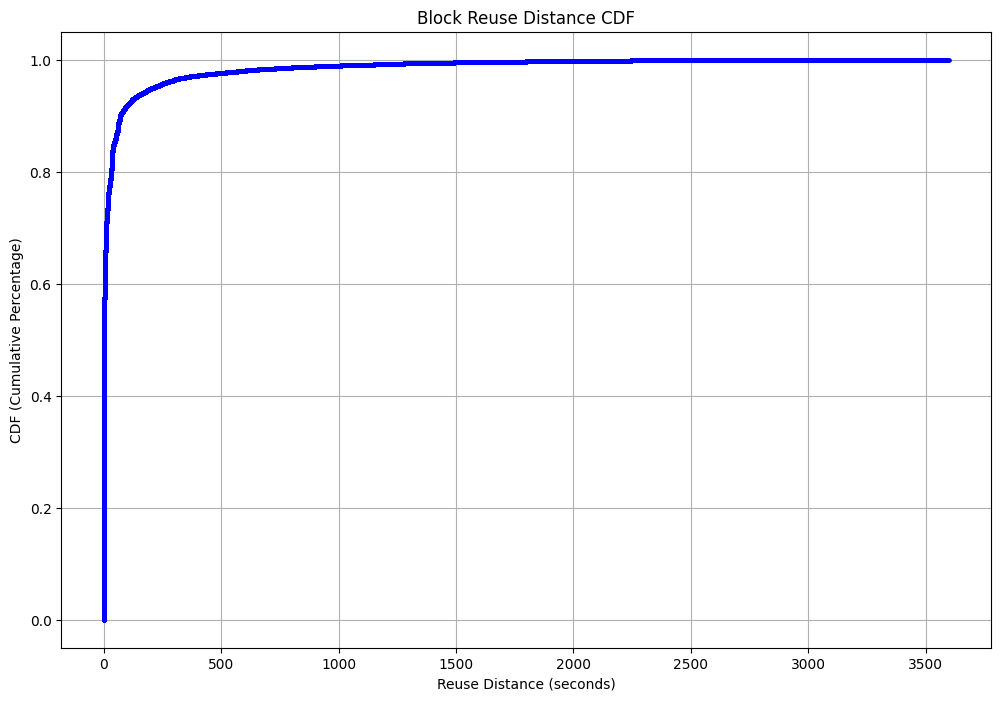

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# 文件路径
file_path = '/home/Data-7T-nvme/lzq/tencent_blk_trace/cbs_trace1/atc_2020_trace/trace_ori/2018-10-01-00'

# 加载 CSV 数据
trace_df = pd.read_csv(file_path, header=None, names=['Timestamp', 'Offset', 'Size', 'IOType', 'VolumeID'])

# 将 Timestamp 转换为 datetime 格式
trace_df['Timestamp'] = pd.to_datetime(trace_df['Timestamp'], unit='s')

# 1. 块重用时间计算（计算每个块的重用距离）
def cal_blk_reuse_distance(trace_df):
    """
    计算每个块的重用距离。
    :param trace_df: DataFrame 包含 trace 数据
    :return: reuse_distances
    """
    # 存储每个块的最后访问时间
    last_access = defaultdict(lambda: np.inf)

    reuse_distances = []  # 用于存储每个块的重用距离

    # 遍历所有的 I/O 请求
    for index, row in trace_df.iterrows():
        blk_id = (row['VolumeID'], row['Offset'] // 512)  # 计算块标识符 (VolumeID, Offset)
        cur_time = row['Timestamp']  # 当前 I/O 请求的时间

        # 如果该块之前访问过，计算重用距离
        if last_access[blk_id] != np.inf:
            reuse_distance = (cur_time - last_access[blk_id]).total_seconds()  # 计算重用时间，单位为秒
            reuse_distances.append(reuse_distance)

        # 更新该块的最后访问时间
        last_access[blk_id] = cur_time

    # 返回重用距离
    return reuse_distances

# 计算所有块的重用距离
reuse_distances = cal_blk_reuse_distance(trace_df)

# 2. 绘制重用距离的 CDF（累积分布图）
def plot_reuse_distance_cdf(reuse_distances):
    """
    绘制重用距离的 CDF 图。
    :param reuse_distances: 重用距离列表
    """
    sorted_distances = sorted(reuse_distances)
    cdf = [i / len(sorted_distances) for i in range(len(sorted_distances))]

    # 绘图
    plt.figure(figsize=(12, 8))
    plt.plot(sorted_distances, cdf, marker='.', markersize=4, color='blue', alpha=0.7)
    plt.xlabel('Reuse Distance (seconds)')
    plt.ylabel('CDF (Cumulative Percentage)')
    plt.title('Block Reuse Distance CDF')
    plt.grid(True)
    plt.show()

# 绘制重用距离 CDF 图
plot_reuse_distance_cdf(reuse_distances)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# 文件路径
file_path = '/home/Data-7T-nvme/lzq/tencent_blk_trace/cbs_trace1/atc_2020_trace/trace_ori/2018-10-01-00'

# 加载 CSV 数据
trace_df = pd.read_csv(file_path, header=None, names=['Timestamp', 'Offset', 'Size', 'IOType', 'VolumeID'])

/tmp/ipykernel_209542/3667526703.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(pad=1.5)  # 调整布局
/tmp/ipykernel_209542/3667526703.py:76: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{save_dir}/Request_Size_CDF_{time_range}.svg", format='svg')
/home/lzq/proj/dataAnalytics/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


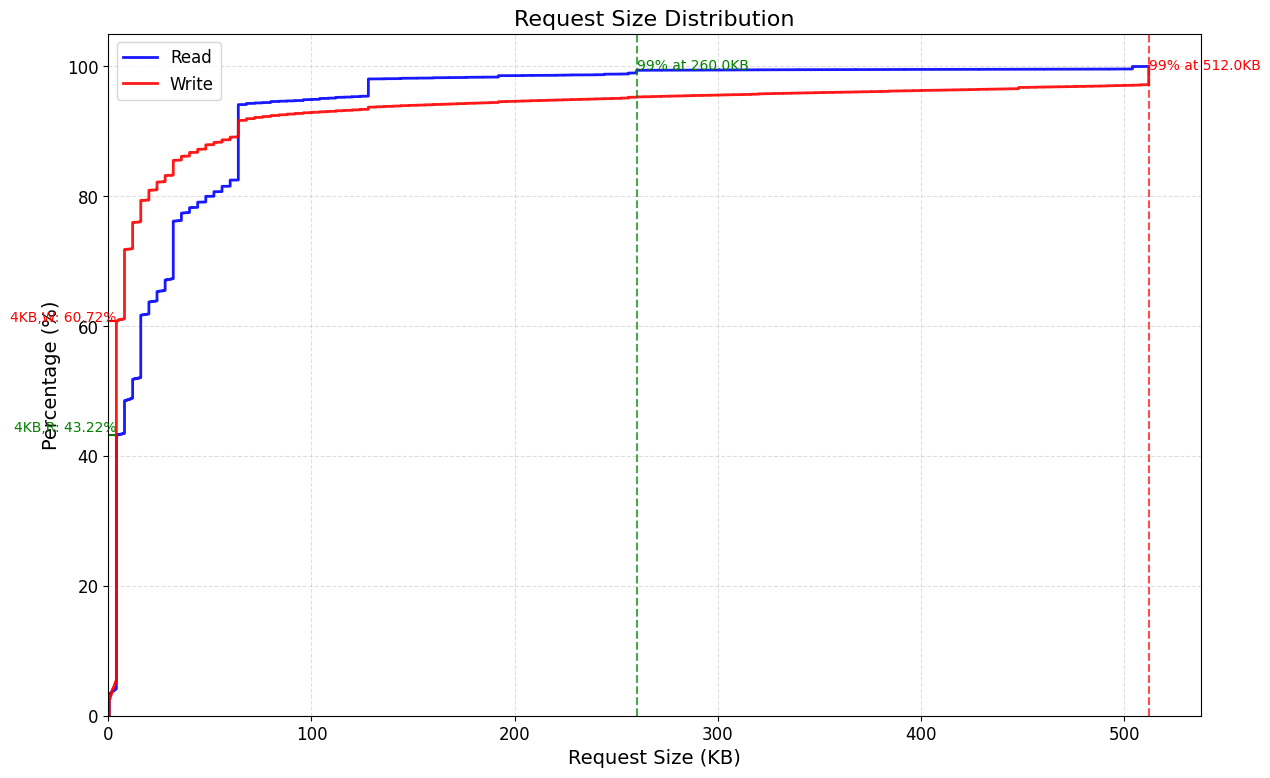

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

def add_point_lines(x, y, color='blue'):
    """绘制P99等特殊点的垂直线和标注"""
    plt.axvline(x=x, color=color, linestyle='--', alpha=0.7)
    plt.text(x, y, f'{y}% at {x}KB', color=color, ha='left', va='bottom')

def plot_req_size_cdf(trace_df):
    # 1. 将时间戳转换为datetime格式
    df = trace_df.copy()
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

    # 2. 获取读写请求长度并排序，转换为 KB
    read_lengths = df[df['IOType'] == 0]['Size'].astype(int) / 2  # 每个扇区大小为 512 字节，转换为KB
    write_lengths = df[df['IOType'] == 1]['Size'].astype(int) / 2

    # 排序
    read_lengths = read_lengths.sort_values().reset_index(drop=True)
    write_lengths = write_lengths.sort_values().reset_index(drop=True)

    # 3. 计算CDF：使用numpy的percentile函数计算百分位数
    read_percentiles = np.linspace(0, 100, len(read_lengths))
    write_percentiles = np.linspace(0, 100, len(write_lengths))

    # 4. 绘制 CDF 图
    plt.figure(figsize=(12, 8))
    plt.plot(read_lengths.values, read_percentiles, linewidth=2, color='blue', alpha=0.9, label='Read')
    plt.plot(write_lengths.values, write_percentiles, linewidth=2, color='red', alpha=0.9, label='Write')

    # 设置坐标轴范围
    plt.xlim(0, plt.gca().get_xlim()[1])
    plt.ylim(0, 105)

    # 5. 设置标签和标题
    plt.xlabel('Request Size (KB)', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.title('Request Size Distribution', fontsize=16, fontweight='normal')

    # 6. 添加图例
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout(pad=1.5)  # 调整布局

    # 7. 计算并标注特殊点
    # 计算小于等于4KB的请求百分比
    read_le_4kb = (read_lengths <= 4).mean() * 100
    write_le_4kb = (write_lengths <= 4).mean() * 100

    # 在图表上添加4KB的标记线和标注
    plt.axhline(y=read_le_4kb, xmax=4 / plt.gca().get_xlim()[1], color='green', linestyle='--', alpha=1)
    plt.axhline(y=write_le_4kb, xmax=4 / plt.gca().get_xlim()[1], color='red', linestyle='--', alpha=1)

    plt.text(4, read_le_4kb, f'4KB,R: {read_le_4kb:.2f}%', color='green', ha='right', va='bottom')
    plt.text(4, write_le_4kb, f'4KB,W: {write_le_4kb:.2f}%', color='red', ha='right')

    # 8. 计算P99和P90点
    read_p99 = np.percentile(read_lengths, 99) if len(read_lengths) > 0 else 0
    write_p99 = np.percentile(write_lengths, 99) if len(write_lengths) > 0 else 0

    if read_p99 > 0:
        add_point_lines(read_p99, 99, color='green')
    if write_p99 > 0:
        add_point_lines(write_p99, 99, color='red')

    # 获取设备ID和时间范围
    dev_id = df['VolumeID'].iloc[0]
    time_range = f"{pd.to_datetime(df['Timestamp'].min()).strftime('%m%d_%H')}-{pd.to_datetime(df['Timestamp'].max()).strftime('%m%d_%H')}"
    
    # 保存图像
    save_dir = f"../SVG/tx/dev-{dev_id}"
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/Request_Size_CDF_{time_range}.svg", format='svg')

    plt.show()

# 示例调用
# 假设 trace_df 是加载后的数据
plot_req_size_cdf(trace_df)


In [ ]:

    plt.show()

# 示例调用
# 假设 trace_df 是加载后的数据
plot_req_size_cdf(trace_df)


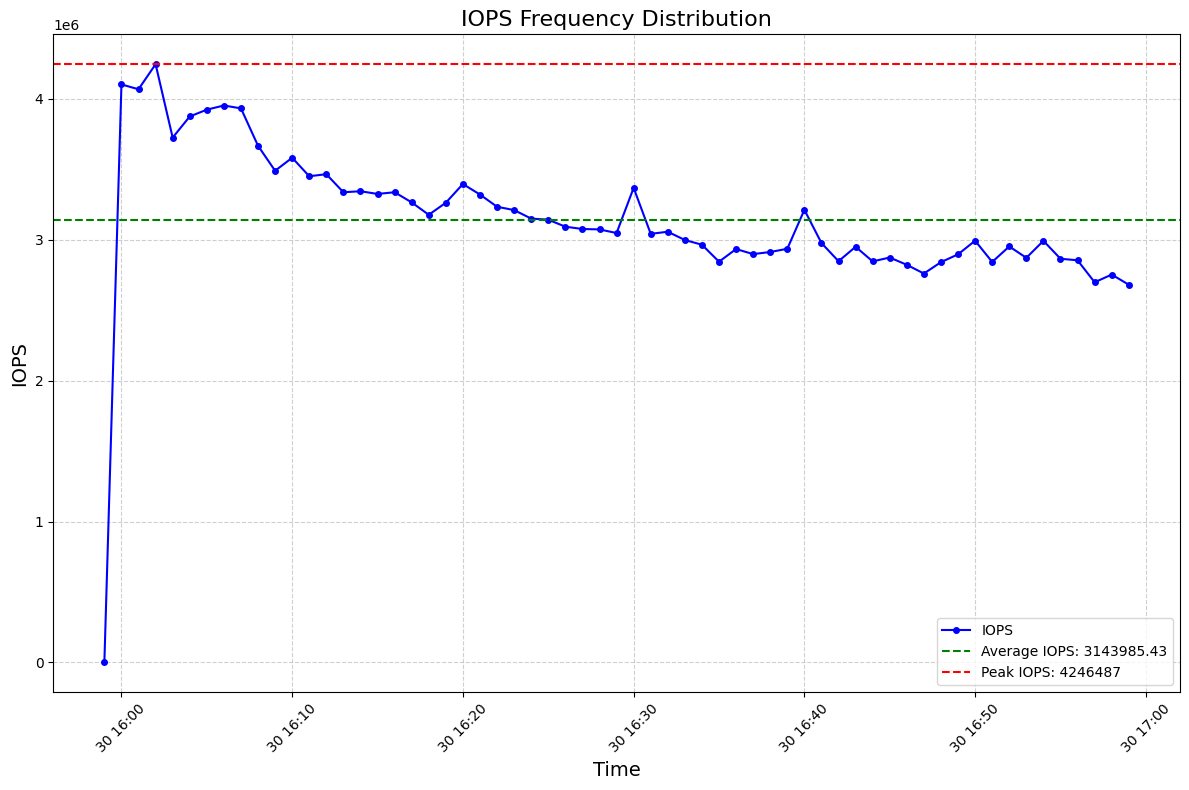

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_req_freq(trace_df, time_interval_seconds):
    """
    绘制请求频率分布图，包括平均IOPS和峰值IOPS
    :param trace_df: 包含跟踪数据的DataFrame
    :param time_interval_seconds: 统计的时间间隔（以秒为单位）
    """
    # 将时间戳转换为datetime格式
    df = trace_df.copy()
    df['timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

    # 按照指定的时间间隔（time_interval_seconds）进行分组
    # 'floor' 方法将时间戳按指定的秒数向下取整，确保所有事件都属于相同的时间段
    time_intervals = df['timestamp'].dt.floor(f'{time_interval_seconds}s')

    # 计算每个时间段的 IOPS（每秒的操作次数）
    iops = df.groupby(time_intervals).size()

    # 计算平均 IOPS 和 峰值 IOPS
    avg_iops = iops.mean()
    peak_iops = iops.max()

    # 绘制 IOPS 图
    plt.figure(figsize=(12, 8))

    # 绘制每个时间段的 IOPS
    plt.plot(iops.index, iops.values, label='IOPS', color='blue', linestyle='-', marker='o', markersize=4)

    # 绘制平均 IOPS
    plt.axhline(avg_iops, color='green', linestyle='--', label=f'Average IOPS: {avg_iops:.2f}')

    # 绘制峰值 IOPS
    plt.axhline(peak_iops, color='red', linestyle='--', label=f'Peak IOPS: {peak_iops}')

    # 设置标签和标题
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('IOPS', fontsize=14)
    plt.title('IOPS Frequency Distribution', fontsize=16, fontweight='normal')

    # 设置网格和图例
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    # 设置 x 轴的时间格式
    plt.xticks(rotation=45)
    plt.tight_layout()

    # 显示图表
    plt.show()

# 示例用法：
# 假设 trace_df 已经加载并包含了适当的时间戳（单位是秒）和其他相关数据
plot_req_freq(trace_df, time_interval_seconds=60)


/tmp/ipykernel_209542/1667196109.py:58: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{save_dir}/3-1-reuse_times_cdf_separate_{time_range}.svg", format='svg')
/home/lzq/proj/dataAnalytics/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


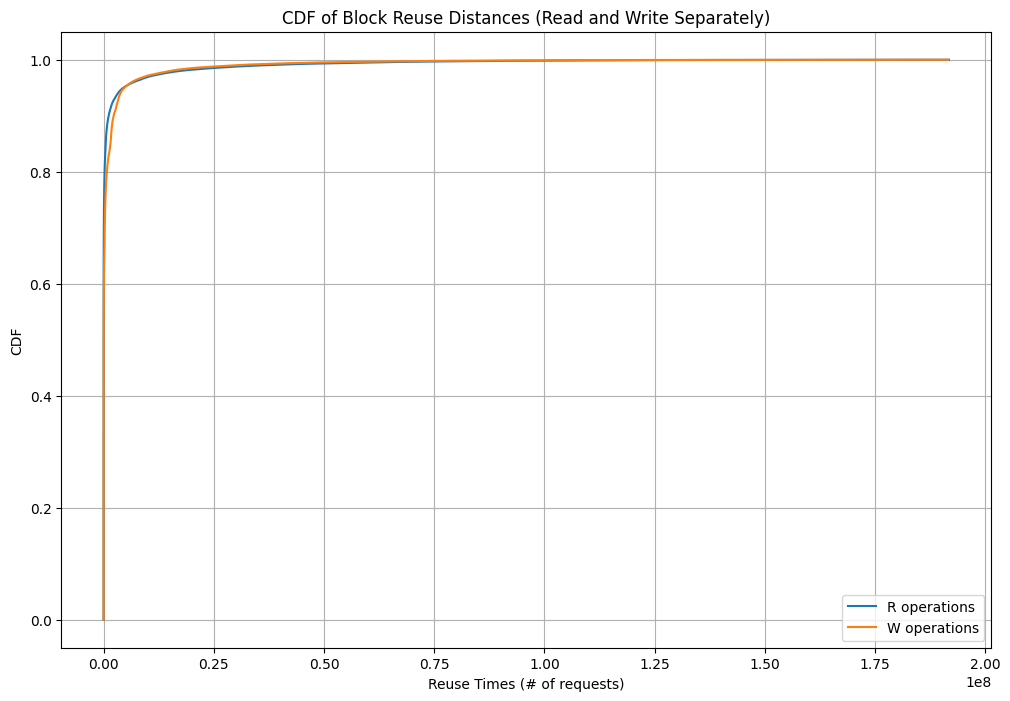

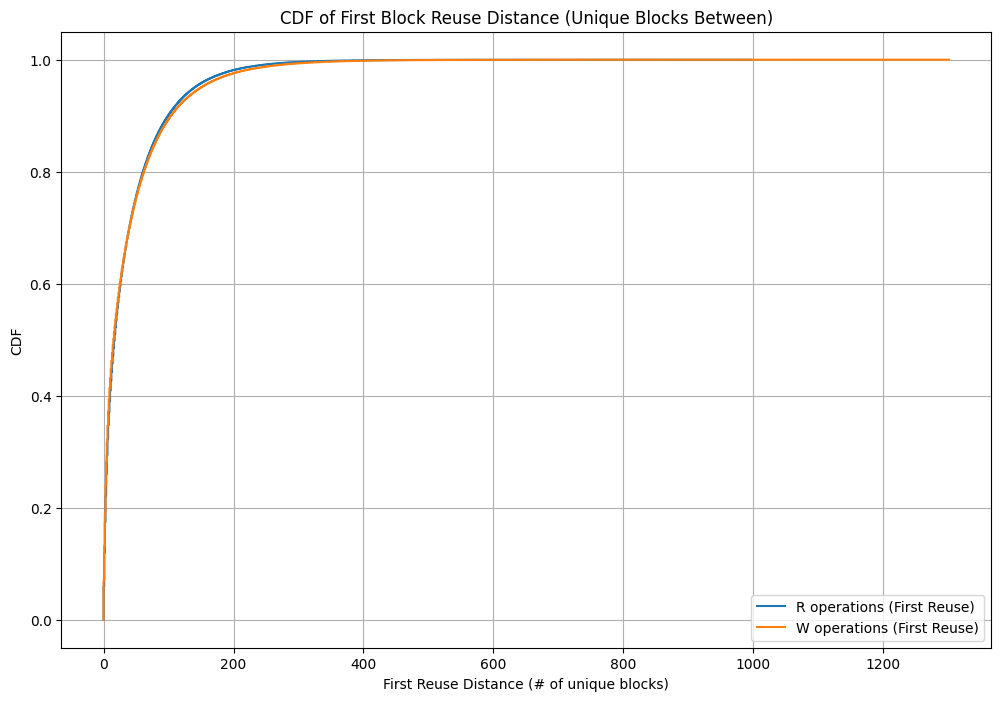

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

chunk_size = 4096  # 假设每块大小为4KB

def plot_reuse_distance_cdf(trace_df): 
    """
    绘制块重用距离的CDF分布图，分别计算读写操作
    :param trace_df: DataFrame 包含 trace 数据
    """
    # 计算块ID
    trace_df['block_id'] = trace_df.apply(lambda x: f"{x['VolumeID']}_{x['Offset'] // chunk_size}", axis=1)
    
    # 分别计算读写请求的重用距离
    reuse_distances = {'R': [], 'W': []}
    
    # 记录每个块上一次读写访问的位置
    last_read = {}
    last_write = {}
    
    # 遍历数据计算重用距离
    for idx, row in trace_df.iterrows():
        block_id = row['block_id']
        op_type = row['IOType']
        
        if op_type == 0:  # Read
            if block_id in last_read:
                distance = idx - last_read[block_id]
                reuse_distances['R'].append(distance)
            last_read[block_id] = idx
        elif op_type == 1:  # Write
            if block_id in last_write:
                distance = idx - last_write[block_id]
                reuse_distances['W'].append(distance)
            last_write[block_id] = idx
    
    # 绘制CDF图
    plt.figure(figsize=(12, 8))
    
    for op_type in ['R', 'W']:
        if reuse_distances[op_type]:
            distances = sorted(reuse_distances[op_type])
            y = [i / len(distances) for i in range(len(distances))]
            plt.plot(distances, y, label=f'{op_type} operations')
    
    plt.grid(True)
    plt.title('CDF of Block Reuse Distances (Read and Write Separately)')
    plt.xlabel('Reuse Times (# of requests)')
    plt.ylabel('CDF')
    plt.legend()
    
    dev_id = trace_df['VolumeID'].iloc[0]
    save_dir = f"../SVG/tx/dev-{dev_id}"
    os.makedirs(save_dir, exist_ok=True)
    time_range = f"{pd.to_datetime(trace_df['Timestamp'].min()).strftime('%m%d_%H')}-{pd.to_datetime(trace_df['Timestamp'].max()).strftime('%m%d_%H')}" 
    plt.savefig(f"{save_dir}/3-1-reuse_times_cdf_separate_{time_range}.svg", format='svg')
    plt.show()


def plot_unique_reuse_cdf(trace_df):
    """
    绘制块首次重用距离的CDF分布图，每个块只统计第一次重用
    重用距离定义为:两次访问之间出现的不同块的数量
    :param trace_df: DataFrame 包含 trace 数据
    """
    # 计算块ID
    df = trace_df.copy()
    df['block_id'] = df.apply(lambda x: f"{x['VolumeID']}_{x['Offset'] // chunk_size}", axis=1)
    
    # 分别计算读写请求的首次重用距离
    reuse_distances = {'R': [], 'W': []}
    
    # 记录每个块最后一次读写访问位置
    last_read = {}
    last_write = {}
    
    # 记录已经计算过重用距离的块
    counted_blocks_read = set()
    counted_blocks_write = set()
    
    # 用于记录每个位置之间出现的块
    blocks_between = {'R': set(), 'W': set()}
    
    # 遍历数据计算重用距离
    for idx, row in df.iterrows():
        block_id = row['block_id']
        op_type = row['IOType']
        
        if op_type == 0:  # Read
            if block_id in last_read and block_id not in counted_blocks_read:
                # 计算两次访问之间出现的不同块的数量
                distance = len(blocks_between['R'])
                reuse_distances['R'].append(distance)
                counted_blocks_read.add(block_id)
                # 重置集合
                blocks_between['R'] = set()
            else:
                # 记录这个块
                blocks_between['R'].add(block_id)
            last_read[block_id] = idx
            
        elif op_type == 1:  # Write
            if block_id in last_write and block_id not in counted_blocks_write:
                # 计算两次访问之间出现的不同块的数量
                distance = len(blocks_between['W'])
                reuse_distances['W'].append(distance)
                counted_blocks_write.add(block_id)
                # 重置集合
                blocks_between['W'] = set()
            else:
                # 记录这个块
                blocks_between['W'].add(block_id)
            last_write[block_id] = idx
    
    # 绘制CDF图
    plt.figure(figsize=(12, 8))
    
    for op_type in ['R', 'W']:
        if reuse_distances[op_type]:
            distances = sorted(reuse_distances[op_type])
            y = np.linspace(0, 1, len(distances))  # 使用linspace生成均匀的y值
            plt.plot(distances, y, label=f'{op_type} operations (First Reuse)')
    
    plt.grid(True)
    plt.title('CDF of First Block Reuse Distance (Unique Blocks Between)')
    plt.xlabel('First Reuse Distance (# of unique blocks)')
    plt.ylabel('CDF')
    plt.legend()
    
    dev_id = df['VolumeID'].iloc[0] 
    save_dir = f"../SVG/tx/dev-{dev_id}"
    os.makedirs(save_dir, exist_ok=True)  
    time_range = f"{pd.to_datetime(df['Timestamp'].min()).strftime('%m%d_%H')}-{pd.to_datetime(df['Timestamp'].max()).strftime('%m%d_%H')}" 
    plt.savefig(f"{save_dir}/3-2-first_reuse_distance_cdf_{time_range}.svg", format='svg')
    plt.show()

plot_reuse_distance_cdf(trace_df)  # 绘制块重用距离的 CDF 图
plot_unique_reuse_cdf(trace_df)    # 绘制块首次重用距离的 CDF 图

唯一块数: 3421473

访问次数统计:
最高访问次数: 533437
平均访问次数: 56.76


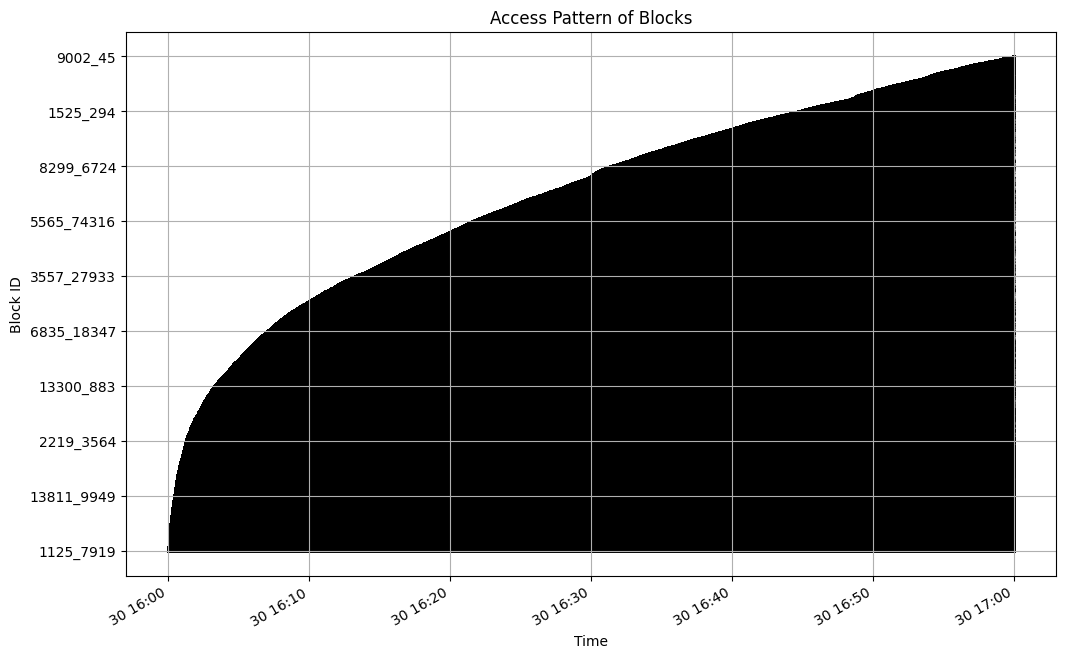

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

chunk_size = 4096  # 假设每块大小为 4KB

def plot_access_pattern(trace_df):
    """
    绘制每分钟第一个访问的块在后续时间的访问情况。
    :param trace_df: DataFrame 包含 trace 数据
    """
    # 计算块ID
    df = trace_df.copy()  # 使用副本避免修改原始数据
    df['block_id'] = df.apply(lambda x: f"{x['VolumeID']}_{x['Offset'] // chunk_size}", axis=1)

    # 将timestamp转换为datetime格式
    df['timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    
    # 设置时间索引
    df.set_index('timestamp', inplace=True)

    # 创建字典来存储块访问记录 {block_id: [timestamps]}
    blk_access = {}
    
    # 对每个请求，计算其覆盖的所有块ID
    for _, row in df.iterrows():
        start_block = row['Offset'] // chunk_size
        end_block = (row['Offset'] + row['Size'] + 4095) // chunk_size
        
        # 为这个请求范围内的每个块记录访问时间
        for block_num in range(start_block, end_block):
            block_id = f"{row['VolumeID']}_{block_num}"
            if block_id not in blk_access:
                blk_access[block_id] = []
            blk_access[block_id].append(row.name)
    
    # 打印一些统计信息
    print(f"唯一块数: {len(blk_access)}")
    print("\n访问次数统计:")
    access_counts = {k: len(v) for k, v in blk_access.items()}
    print(f"最高访问次数: {max(access_counts.values())}")
    print(f"平均访问次数: {sum(access_counts.values()) / len(access_counts):.2f}")

    # 准备绘图数据
    plot_data = []
    for block_id, timestamps in blk_access.items():
        plot_data.extend([(ts, block_id) for ts in timestamps])
    plot_df = pd.DataFrame(plot_data, columns=['timestamp', 'block_id'])
    plot_df.sort_values('timestamp', inplace=True)

    # 绘图
    plt.figure(figsize=(12, 8))  # 设置图形大小为12x8英寸
    plt.title('Access Pattern of Blocks')  # 设置图表标题
    plt.xlabel('Time')  # 设置x轴标签
    plt.ylabel('Block ID')  # 设置y轴标签

    plt.scatter(plot_df['timestamp'], plot_df['block_id'], 
            s=0.5,           # 设置点的大小
            color='black',   # 设置颜色为黑色
            alpha=0.1,       # 设置透明度
            marker='.')      # 使用实心圆点

    plt.gcf().autofmt_xdate()  # 自动格式化x轴日期标签，使其倾斜以避免重叠
    
    unique_block_ids = plot_df['block_id'].unique()  # 获取唯一的块ID列表
    num_ticks = min(10, len(unique_block_ids))  # 设置y轴刻度数量，最多10个
    tick_locations = np.linspace(0, len(unique_block_ids) - 1, num_ticks, dtype=int)  # 计算刻度位置
    plt.yticks(tick_locations, [unique_block_ids[i] for i in tick_locations])  # 设置y轴刻度标签

    plt.grid(True)  # 添加网格线

    time_range = f"{plot_df['timestamp'].min().strftime('%m%d_%H')}-{plot_df['timestamp'].max().strftime('%m%d_%H')}"
    dev_id = df['VolumeID'].iloc[0]  
    save_dir = f"../SVG/tx/dev-{dev_id}"  
    os.makedirs(save_dir, exist_ok=True)  
    plt.savefig(f"{save_dir}/access_pattern_{time_range}.svg")  # 保存图形为SVG文件
    plt.show()  # 显示图形

# 示例调用
plot_access_pattern(trace_df)


唯一块数: 22629870

访问次数统计:
最高访问次数: 215758
平均访问次数: 8.47


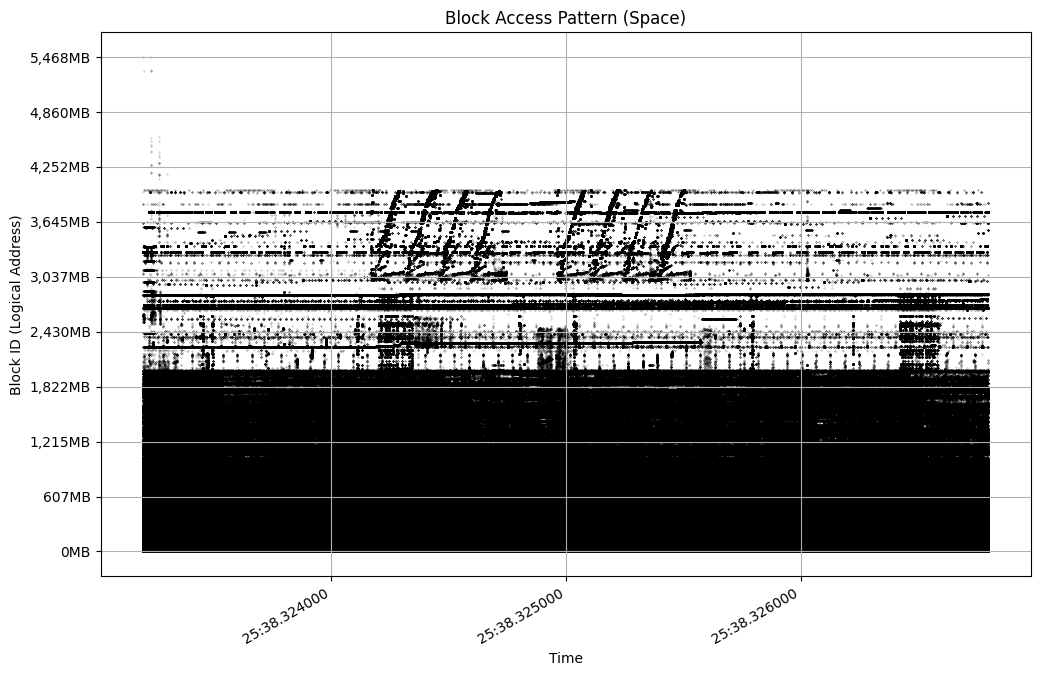

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

chunk_size = 4096  # 每块大小为 4KB，假设为标准块大小（可根据实际情况调整）

def plot_access_pattern_space(global_df):
    """
    绘制每分钟第一个访问的块在后续时间的访问情况。
    :param trace_df: DataFrame 包含 trace 数据
    """
    df = global_df.copy()  # 使用副本避免修改原始数据
    df['timestamp'] = pd.to_datetime(df['Timestamp'], unit='us')  # 转换时间戳为 datetime 格式
    
    # 创建块访问字典,记录每个块的访问时间
    blk_access = {}
    for _, row in df.iterrows():
        block_id = row['Offset']  # 使用偏移量（逻辑地址）作为块ID
        timestamp = row['timestamp']
        
        if block_id not in blk_access:
            blk_access[block_id] = []
        blk_access[block_id].append(timestamp)
    
    # 打印一些统计信息
    print(f"唯一块数: {len(blk_access)}")
    print("\n访问次数统计:")
    access_counts = {k: len(v) for k, v in blk_access.items()}
    print(f"最高访问次数: {max(access_counts.values())}")
    print(f"平均访问次数: {sum(access_counts.values()) / len(access_counts):.2f}")
    
    # 准备绘图数据
    plot_data = []
    for block_id, timestamps in blk_access.items():
        plot_data.extend([(ts, block_id) for ts in timestamps])
    plot_df = pd.DataFrame(plot_data, columns=['timestamp', 'block_id'])
    plot_df.sort_values('timestamp', inplace=True)

    # 绘图
    plt.figure(figsize=(12, 8))  # 设置图形大小为12x8英寸
    plt.title('Block Access Pattern (Space)')
    plt.xlabel('Time')  # 设置x轴标签
    plt.ylabel('Block ID (Logical Address)')  # 设置y轴标签

    plt.scatter(plot_df['timestamp'], plot_df['block_id'],
                s=0.2,  # 设置点的大小
                color='black',  # 设置颜色为黑色
                alpha=0.5,  # 设置透明度
                marker='.')  # 使用实心圆点

    plt.gcf().autofmt_xdate()  # 自动格式化x轴日期标签，使其倾斜以避免重叠

    # 设置y轴刻度,将块ID转换为 MB 单位
    unique_block_ids = sorted(plot_df['block_id'].unique())
    num_ticks = 10  # 设置y轴刻度数量
    tick_locations = np.linspace(min(unique_block_ids), max(unique_block_ids), num_ticks)
    plt.yticks(tick_locations, [f"{int(loc/1024/1024):,}MB" for loc in tick_locations])  # 转换为MB

    plt.grid(True)  # 添加网格线

    # 保存图片
    time_range = f"{pd.to_datetime(plot_df['timestamp'].min()).strftime('%m%d_%H')}-{pd.to_datetime(plot_df['timestamp'].max()).strftime('%m%d_%H')}"
    dev_id = df['VolumeID'].iloc[0]  # 获取设备ID（假设存在VolumeID列）
    save_dir = f"../SVG/tx/dev-{dev_id}"
    os.makedirs(save_dir, exist_ok=True)  # 创建目录（如果不存在）
    plt.savefig(f"{save_dir}/access_pattern_space_{time_range}.svg")  # 保存图形为SVG文件
    plt.show()  # 显示图形

# 示例调用
# 假设global_df 是加载后的数据，包含列 'Timestamp', 'Offset', 'Size', 'IOType', 'VolumeID'
plot_access_pattern_space(trace_df)


In [9]:
import pandas as pd
import os
import traceback
from concurrent.futures import ThreadPoolExecutor

def load(device_id, start_hour=0, duration_hours=2):
    """
    对指定设备进行完整分析并生成所有图表
    :param device_id: 设备ID
    :param start_hour: 开始分析的小时数(从凌晨算起)
    :param duration_hours: 分析时长(小时)
    """
    # 设置文件路径
    # 假设 trace 文件按照设备编号和日期时间命名，使用类似 '2018-10-01-00.csv' 格式的文件
    trace_file = f"/home/Data-7T-nvme/lzq/tencent_blk_trace/cbs_trace1/atc_2020_trace/trace_ori/{start_hour:02d}/{device_id}-{start_hour:02d}.csv"
    
    # 假设从 2018-10-01 开始的时间戳
    t_0 = pd.Timestamp("2018-10-01 00:00:00")
    current_start = t_0 + pd.Timedelta(hours=start_hour)
    
    print(f"加载设备 {device_id}, 时间范围: {current_start} + {duration_hours}小时")
    
    # 加载数据
    df = loadcsv_dask(
        trace_file,
        blksize="900MB",
        start_time=current_start.strftime("%Y-%m-%d %H:%M:%S.%f"),
        nhours=duration_hours
    )
    
    print_statistics(df)
    return df

def process_device_data(device_id, time_period, global_df):
    try:
        # 获取设备数据
        dev_df = global_df[time_period][device_id]
        
        if dev_df is None or len(dev_df) == 0:
            print(f"设备 {device_id} 数据为空, 跳过")
            return
        
        start_time = pd.to_datetime(dev_df['timestamp'].min())
        print(f"\n设备 {device_id} 时间段: {start_time} 数据量: {len(dev_df)} 条记录")
        
        # 图表生成
        plot_req_size_cdf(dev_df)
        plot_req_freq(dev_df, 10)  # 假设每10分钟为一个时间间隔
        plot_reuse_distance_cdf(dev_df)
        plot_unique_reuse_cdf(dev_df)
        plot_access_pattern(dev_df)
        plot_access_pattern_space(dev_df)
        
        print(f"设备 {device_id} 完成")
    except Exception as e:
        print(f"设备 {device_id} 处理时发生错误: {str(e)}")
        traceback.print_exc()

def load_and_process_all(device_ids, n_hours=24):
    global_df = [[None for _ in range(len(device_ids))] for _ in range(n_hours // 2)]  # 2小时一个时间段
    
    # Load data in parallel (for each time period)
    with ThreadPoolExecutor() as executor:
        futures = []
        
        for hour_idx, hour in enumerate(range(0, n_hours, 2)):
            global_df[hour_idx] = [None] * len(device_ids)
            print(f"\n开始加载 {hour:02d}:00 - {hour+2:02d}:00 的数据")
            
            # 为每个设备加载数据
            for dev_idx, device_id in enumerate(device_ids):
                future = executor.submit(load, device_id, start_hour=hour, duration_hours=2)
                futures.append((future, hour_idx, dev_idx))
        
        # 等待所有数据加载完成
        for future, hour_idx, dev_idx in futures:
            try:
                global_df[hour_idx][dev_idx] = future.result()
            except Exception as e:
                print(f"加载设备 {device_ids[dev_idx]} 时发生错误: {str(e)}")
    
    # 处理每个时间段的图表生成
    with ThreadPoolExecutor() as executor:
        futures = []
        for time_period in range(len(global_df)):
            for dev_idx, dev_df in enumerate(global_df[time_period]):
                if dev_df is not None:
                    futures.append(executor.submit(process_device_data, dev_idx, time_period, global_df))
        
        # 等待所有任务完成
        for future in futures:
            future.result()

    print("\n数据加载完成")

# 示例调用
device_ids = [1, 2, 3]  # 假设有3个设备
load_and_process_all(device_ids, n_hours=24)



开始加载 00:00 - 02:00 的数据
加载设备 1, 时间范围: 2018-10-01 00:00:00 + 2小时
加载设备 2, 时间范围: 2018-10-01 00:00:00 + 2小时
加载设备 3, 时间范围: 2018-10-01 00:00:00 + 2小时

开始加载 02:00 - 04:00 的数据
加载设备 1, 时间范围: 2018-10-01 02:00:00 + 2小时
加载设备 2, 时间范围: 2018-10-01 02:00:00 + 2小时
加载设备 3, 时间范围: 2018-10-01 02:00:00 + 2小时

开始加载 04:00 - 06:00 的数据

开始加载 06:00 - 08:00 的数据
加载设备 1, 时间范围: 2018-10-01 04:00:00 + 2小时
加载设备 2, 时间范围: 2018-10-01 04:00:00 + 2小时
加载设备 3, 时间范围: 2018-10-01 04:00:00 + 2小时
加载设备 1, 时间范围: 2018-10-01 06:00:00 + 2小时

开始加载 08:00 - 10:00 的数据
加载设备 2, 时间范围: 2018-10-01 06:00:00 + 2小时
加载设备 3, 时间范围: 2018-10-01 06:00:00 + 2小时
加载设备 1, 时间范围: 2018-10-01 08:00:00 + 2小时
加载设备 2, 时间范围: 2018-10-01 08:00:00 + 2小时
加载设备 3, 时间范围: 2018-10-01 08:00:00 + 2小时

开始加载 10:00 - 12:00 的数据

开始加载 12:00 - 14:00 的数据
加载设备 1, 时间范围: 2018-10-01 10:00:00 + 2小时
加载设备 2, 时间范围: 2018-10-01 10:00:00 + 2小时
加载设备 3, 时间范围: 2018-10-01 10:00:00 + 2小时
加载设备 1, 时间范围: 2018-10-01 12:00:00 + 2小时
加载设备 2, 时间范围: 2018-10-01 12:00:00 + 2小时
加载设备 3, 时间范围: 2018-10-01 12:00:0